# Jupyter notebook to reproduce some of the results of Chapter 7 of the thesis 

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import scipy.integrate as intg
from scipy import linalg as scpal
from PIL import Image
from matplotlib import cm
import itertools
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [5]:
def RMmodel(v,F,m, BC="periodic"):
    T=np.zeros([])
    H=np.diag(T[0:F-1],1)+np.diag(T[0:F-1],-1)+m*np.asarray([(-1)**j for j in range(F)])
    if BC=="periodic":
        H[0,F-1]=t[F-1]
        H[F-1,0]=t[F-1]
    return H

def getspect(H):
    "returns 1) eigenvalues of H and 2) the eigenvectors of H. Assumes the Hamiltonian is Hermitian"  
    eigval, eigvect=np.linalg.eig(H)
    idx = eigval.argsort()
    eigval = eigval[idx]
    eigvect= eigvect[:,idx]
    return (eigval,eigvect)


def FiboWord(n): #consists of N=Fibonumb((n)) letters
    if n<1:
        print("Incorrect input")
    elif n==1:
        return "0" #first Fibonacci word
    elif n==2:
        return "01" #second Fibonacci word
    else:
        Sn_1 = "0"
        Sn = "01"
        tmp = "" 
        for i in range(2, n ): 
            tmp = Sn 
            Sn += Sn_1 
            Sn_1 = tmp 
        return Sn 

def Fibonr(n): 
    if n<0: 
        print("Incorrect input") 
    # first Fibonacci number is 1 
    elif n==0: 
        return 1
    # second Fibonacci number is 1 
    elif n==1: 
        return 1
    else: 
        return Fibonr(n-1)+Fibonr(n-2)
    
def PellWord(n): #consists of N=Pellnr((n+2)) letters
    if n<1:
        print("Incorrect input")
    elif n==1:
        return "0" # First Pell word
    elif n==2:
        return "001" #Second Pell word
    else:
        Sn_1= "0"
        Sn= "001"
        tmp=""
        for i in range(2,n+1):
            tmp=Sn
            Sn=Sn+Sn+Sn_1
            Sn_1=tmp
        return Sn

def Pellnr(n):
    if n<0:
        print("Incorrect input")
    elif n==0:
        return 0 #first Pell nr is 0
    elif n==1:
        return 1 #second Pell nr is 1
    else: 
        return 2*Pellnr(n-1)+Pellnr(n-2)
    
def TriboWord(n):
    if n<1:
        print("Incorrect input.")
    elif n==1:
        return "0" #first Tribo word
    elif n==2:
        return "01" #second Tribo word
    elif n==3:
        return "0102" #third Tribo word
    else:
        Sn_2="0"
        Sn_1="01"
        Sn="0102"
        tmp1=""
        tmp2=""
        for i in range(2,n+1):
            tmp1=Sn
            tmp2=Sn_1
            Sn=Sn+Sn_1+Sn_2
            Sn_1=tmp1
            Sn_2=tmp2
        return Sn

def Tribonr(n):
    if n<0:
        print("Incorrect input")
    elif n==0:
        return 1 #first trib nr
    elif n==1: 
        return 1 #second trib nr
    elif n==2:
        return 2 #third trib nr
    else:
        return Tribonr(n-1)+Tribonr(n-2)+Tribonr(n-3)
    
def TMWord(n): #n generation Thue-Morse word. 
    if n<1:
        print("Incorrect input")
    elif n==1:
        return "01" # First TM word
    elif n==2:
        return "0110" #Second TM word
    else:
        def bitnegation(word):
            negword=""
            for n in range(len(word)):
                if word[n]=="0":
                    negword+="1"
                elif word[n]=="1":
                    negword+="0"
            return negword
        Sn_1= "01"
        Sn= ""
        for i in range(2,n+1):
            Sn=Sn_1+bitnegation(Sn_1)
            Sn_1=Sn
        return Sn
    
def RSWord(n): #n generation Rudin-Shapiro word.
    def count_substring(string, sub_string):
        count = 0
        for pos in range(len(string)):
            if string[pos:].startswith(sub_string):
                count += 1
        return count
    Sn=""
    for i in range(0,2**n):
        if count_substring(bin(i)[2:],"11")%2==0:
            Sn+="0"
        else:
            Sn+="1"
    return Sn

def bihopping(word, N, ts, tw):
    #generate the hopping sequence of tw and ts from a binary word of length N
    T=np.zeros([N])
    for i in range(N):
        if word[i]=='0':
            T[i]=tw
        elif word[i]=='1':
            T[i]=ts
    return T

def trihopping(word, N, ts, tw, tww):
    #generate the hopping sequence of ts, tw and tww  from a ternary word of length N
    T=np.zeros([N])
    for i in range(N):
        if word[i]=='0':
            T[i]=tww
        elif word[i]=='1':
            T[i]=tw
        elif word[i]=="2":
            T[i]=ts
    return T


def currentpumped(psi, E, filling, t):
    """current pumped from the eigenstates of the Hamiltonian psi(x,n,t), with x position, n eigenstate index
    and t time (between t=0 and t=1), and their instantaneous eigenenergies E(n,t). Ib is computed for a filling (0,0.5)."""
    

    N2 = len(E[0,:]) #number of sites => total dim of Hamiltonian
    Nf = int(filling*N2) #number of states below Ef
    tt = len(E[:,0]) #total number of time steps
    TT = int(t*tt) #portion of time steps

    U = np.zeros([TT, Nf,Nf], dtype=np.complex128) #projected exp position operator
    V = np.zeros([TT, Nf,Nf], dtype=np.complex128) #projected time translation operator

    X = np.diag(np.exp(2*np.pi*1j*(np.arange(N2)+1)/N2))
    Xin = np.diag(np.exp(-2*np.pi*1j*(np.arange(N2)+1)/N2))

    Ibott2 = 0
    
    for i in range(TT-1):
        
        U[i,:,:] = psi[i,:,:Nf].T.conj() @ X @ psi[i, :, :Nf]
        V[i,:,:] = psi[i,:,:Nf].T.conj()@ psi[i+1,:,:Nf]
            
    U[TT-1,:,:] = psi[TT-1,:,:Nf].T.conj() @ X @ psi[TT-1,:,:Nf]
    V[TT-1,:,:] = psi[TT-1,:,:Nf].T.conj()@ psi[0,:,:Nf]
            
            
    for i in range(TT-1):
        a = V[i,:,:] @ U[i+1,:,:]
        b = V[i,:,:].T.conj() @ U[i,:,:].T.conj()
        
        Ibott2 += np.sum(np.log(np.linalg.eigvals(a @ b)))/(2*np.pi)
        
#     U = psi[0,:,:Nf].T.conj() @ X @ psi[0, :, :Nf]
#     V = psi[TT-1,:,:Nf].T.conj()@ psi[0,:,:Nf]
#     W = psi[0,:,:Nf].T.conj()@ psi[TT-1,:,:Nf]
#     Z = psi[TT-1,:,:Nf].T.conj() @ Xin @ psi[TT-1, :, :Nf]
    
#     a = V @ U 
#     b = W @ Z
    
#     Ibott2 += np.sum(np.log(np.linalg.eigvals(a @ b)))/(2*np.pi)

    return Ibott2.imag

def segcolor(E, vr, N, TT):         
    def normalize_rgb(*args):
        return tuple(arg / 255 for arg in args)

    # Define the RGB for blue and red
    blue = normalize_rgb(100, 142, 232)
    red = normalize_rgb(255, 163, 163)

    # Create a color dictionary for linear interpolation across the normalized range
    cdict1 = {
        'red':   [(0.0, blue[0], blue[0]),
                  (0.5, 1.0, 1.0),    # Optionally adjust the middle point color
                  (1.0, red[0], red[0])],
        'green': [(0.0, blue[1], blue[1]),
                  (0.5, 1.0, 1.0),    # Optionally adjust the middle point color
                  (1.0, red[1], red[1])],
        'blue':  [(0.0, blue[2], blue[2]),
                  (0.5, 1.0, 1.0),    # Optionally adjust the middle point color
                  (1.0, red[2], red[2])] }

    blue_red = LinearSegmentedColormap('BlueRed', cdict1)

    r = np.arange(1,N+1) #Position operator


    #HERE
    color = np.zeros([N,TT]) #colored line of spect depending on value of expectation of position operator
    spectrum = np.zeros([N,TT]) 


    for i in tqdm(range(TT)):
        en, vec = E[i,:], vr[i,:,:]
        vec = vec[:,np.argsort(en.real)]
        spectrum[:,i] = np.sort(en.real)
        color[:,i] = np.sum(np.matmul(np.diag(r),np.abs(vec)**2),axis=0)

    color = color[:,0:-1].flatten() 

    #HERE
    segments = np.zeros([N*(TT-1),2,2]) # wtf is this? 
    for i in range(N):
        points1 = np.array([T, spectrum[i,:]]).T.reshape(-1, 1, 2)
        segments[(TT-1)*i:((TT-1)*(i+1)),:,:] = np.concatenate([points1[:-1], points1[1:]], axis=1)
        
    return (color, segments, r, spectrum)

def TDBerryphase(H,fill,TT,K):
    """Time-dependent Berry phase. TT: time steps,  K: momentum steps, fill: filling, Tf: Hopping word"""
    
    kk=K
    NTM=len(H[0,0,0,:])
    
    ETM = np.zeros([TT, kk, NTM], dtype=np.complex128)
    vrTM = np.zeros([TT, kk, NTM,NTM], dtype=np.complex128)


    for tt in tqdm(range(TT)):
        for i in range(kk):

            vrTM[tt,i,:,:] = getspect(H[tt,i,:,:])[1]
            
    psif=vrTM[:,:,:,:fill]

    #Periodic gauge fixing
    for j in range(NTM):
        psif[:,kk-1,j,:] = np.exp(-1j*2*np.pi*(j+1))*psif[:,0,j,:]

    # S = np.diag(np.ones(fill))
    ph = np.zeros(TT)

    for i in range(TT):    
        M = np.diag(np.ones(fill))
        for j in range(kk-1):
            S = psif[i,j,:,:].T.conj()@ psif[i,j+1,:,:]
            M =  M @ S 

        ph[i] = -np.sum(np.log(np.linalg.eigvals(M))).imag
        
    return ph


def polsusc(Ham, Efs, Efermi, Ns, Nc):
    """Efs is the Electric field strength, Efermi is the set of Fermi energies we check this for, T is the hopping array, Ns is
    the number of site in the cell and Nc is the number of cells."""
    a = Ns # cell length
    F = Ns*Nc # total number of sites

    De=np.abs(Efs[2]-Efs[1])
        
    #position operator, with x=0 being the origin. Nc must be even for this to work being half the amount of sites (amount of unit cells). 
    #We split it into A and B sublattices; somehow best choice for ham with clear sublattices, e.g SSH, Rice Mele...
    X=np.zeros([F,F])
    for i in range(1, Nc+1):
        for j in range(1, Ns+1):
            xi = (2*(j)-1)/(2*Ns) + i-1 -Nc/2
            X[(j-1)+Ns*(i-1), (j-1)+Ns*(i-1)] = xi

    LE=Efermi
    kk=len(Efs) # electric field strength array length
    P0=np.zeros([kk]) #Polarization as a function of fermi energy and electric field str

    Eigs=np.zeros([F,kk])
    for i in tqdm(range(kk)):
        H=Ham+Efs[i]*(a*X)
        Eigs[:,i]=getspect(H)[0]

    syslength = a*(Nc-1/Ns)
    for j in range(kk-1):
        if len(np.where(Eigs[:,kk//2]<=LE)[0])==0:
            P0[j]=0
        else:
            ll=len(np.where(Eigs[:,kk//2]<=LE)[0])
            P0[j]=-np.sum((Eigs[0:ll,j+1]-Eigs[0:ll,j])/(Efs[j+1]-Efs[j]))/syslength
    return (Eigs, P0)

def generate_vectors(length, num_nonzero):
    vectors = []
    for k in range(num_nonzero + 1):
        for comb in itertools.combinations(range(length), k):
            vector = [1 if i in comb else 0 for i in range(length)]
            vectors.append(vector)
    return vectors

def EntSpect(e,p,Ef,L,N, plot=False):
    """function to calculate first 200 entanglement eigenvalues for a system of quadratic fermions in 1D, using the 
    correlation matrix method. e is the energy spectrum of the system, p are the corresponding eigenstates, Ef the 
    filling , L the size of the subsystem, N the max occupation number we use for our calculations.
    If you want to see the plot, set it to True"""
    
    n = generate_vectors(L, N)  #generates nr of possible configurations of 0,...,N fermions in L single-particle states
    z=len(n) #number of such configurations we use to compute entanglement spectrum
    S=int(len(e)/2) # We fix our subsystem to start at half the full system
    
    Y=np.zeros([z,2]) #This is where we will store the calculated eigenvalues
    
    If= np.arange(0, Ef) #indices of states with E<E_Fermi

    E=e[If] #energies up to max E<E_Fermi
    P=p[:,If] #corresponding wavefunction
    
    #This part is based on the correlation matrix method in the Majorana basis (see Vidal? paper)
    G=np.zeros([L,L]) #correlation matrix modified (majorana basis)
    for i in range(L):
        for j in range(L):
            if i==j:
                G[i,j]=np.sum(P[S+i,:].conj()*P[S+j,:])+np.sum(P[S+j,:].conj()*P[S+i,:])-1
            else:
                G[i,j]=np.sum(P[S+i,:].conj()*P[S+j,:])+np.sum(P[S+j,:].conj()*P[S+i,:])

    GG=np.matmul(G.transpose(),G)
    nu=np.linalg.eig(GG)[0]
    idx = nu.argsort()
    nu = np.sqrt(np.abs(nu[idx])) #These represent the eigenvalues of the correlation function in the complex fermion basis
    for i in range(len(nu)):
        if nu[i]>1:
            nu[i]=1 # numerically fixing unphysical eigenvalues
            
#     y=np.array([nu[j] for j in range(d)])
#     y=nu[np.where(nu<=1)]
    yy=len(nu)
    
    for j in tqdm(range(z)):
        V=np.array([(1+(-1)**(n[j][k])*nu[k])/2 for k in range(yy)]) 
        Y[j,:]=np.asarray([np.sum(n[j]),np.prod(V)]) # the formula to calculate the entenglement eigenvalues
        
    #This part is to sort the eigenvalues and the select just the first 200 and organize them according to the occupation
    #number configuration 
    
    KK=Y[:,1].argsort()
    Y=Y[KK,:]
    I=np.where(Y[:,1]>0); #We pick the indices of the all eigenvalues that are physical
    YY=Y[I[0],:]
    nr=200
    Z=-np.log(YY[:,1]) 
    z=np.flip(Z[len(Z)-nr:len(Z)]) # This is the final array of eigenvalues
    x=np.flip(YY[len(Z)-nr:len(Z),0]) #This is the final array of occupation number
    
    if plot==True:
        plt.figure(figsize=(3.5,5))

        plt.scatter(x,z, marker="_", s=700, color=(0,0,.8))

        for i in range(len(z)-1):
            if np.abs(z[i]-z[i+1])<1e-1 and x[i]==x[i+1]:
                plt.scatter(x[i],z[i], marker="_", s=700, color=(.8,0,0))
                plt.scatter(x[i+1],z[i+1], marker="_", s=700, color=(.8,0,0))

        plt.ylabel("$\\xi_\\alpha$", fontsize=15);
        plt.xlabel("$n$", fontsize=15);
        plt.xlim(-0.5,4.5);
    
    return (x,z)

## Calculating the time-dependent Berry phase for each of the four models treated in the chapter: the Rice-Mele model, the Fibonacci, the Tribonacci, and the Thue-Morse chains

In [5]:
# Yoshi RM model
D, d0, h0, NRM = 2, 1, 1, 50;
TT=101
T = np.linspace(0, 2*np.pi,TT)
d = d0*np.cos(T)
h = h0*np.sin(T)

ERM=np.zeros([TT,NRM], dtype=np.complex128)
vrRM=np.zeros([TT,NRM,NRM], dtype=np.complex128)


for i in tqdm(range(TT)):
    
    t=np.asarray([D-(-1)**(j+1)*d[i] for j in range(NRM)])  
    u=np.asarray([-(-1)**(j+1)*h[i] for j in range(NRM)])
    
    H=np.diag(t[0:NRM-1],1)+np.diag(t[0:NRM-1],-1)+np.diag(u)
#     H[0,NRM-1]=t[NRM-1]
#     H[NRM-1,0]=t[NRM-1]
    ERM[i,:], vrRM[i,:,:]=getspect(H)

100%|██████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 2220.16it/s]


In [6]:
# Fibonacci Yoshi RM 
D, d0, h0, n=2, 1, 1, 8;
NFib=Fibonr(n);
# TT=501
# T = np.linspace(0, 2*np.pi,TT)
d = d0*np.cos(T)
h = h0*np.sin(T)

H=np.zeros([TT,NFib,NFib], dtype=np.complex128)
EFib=np.zeros([TT,NFib], dtype=np.complex128)
vrFib=np.zeros([TT,NFib,NFib], dtype=np.complex128)


Tf=bihopping(FiboWord(n),NFib,1, -0.5)

for i in tqdm(range(TT)):
    t=D+Tf*d[i]
    u=+Tf*h[i]
    H[i,:,:]=np.diag(t[0:NFib-1],1)+np.diag(t[0:NFib-1],-1)+np.diag(u)
#     H[i,0,NFib-1]=t[NFib-1]
#     H[i,NFib-1,0]=t[NFib-1]

    EFib[i,:], vrFib[i,:,:]=getspect(H[i,:,:])

100%|███████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 924.74it/s]


In [7]:
# Tribonacci Yoshi RM 

D, d0, h0, n=2, 1, 1, 7;
cutoff = 0
NTrib = Tribonr(n) - cutoff
# TT=501
# T = np.linspace(0, 2*np.pi,TT)
d = d0*np.cos(T)
h = h0*np.sin(T)

ETrib=np.zeros([TT,NTrib], np.complex128)
vrTrib=np.zeros([TT,NTrib,NTrib], np.complex128)


Tf=trihopping(TriboWord(n),NTrib,-1,-2, 1.8)

for i in tqdm(range(TT)):
    t=D-Tf*d[i]
    u=-Tf*h[i]

    H=np.diag(t[0:NTrib-1],1)+np.diag(t[0:NTrib-1],-1)+np.diag(u)
#     H[0,NTrib-1]=t[NTrib-1]
#     H[NTrib-1,0]=t[NTrib-1]
    
    ETrib[i,:], vrTrib[i,:,:]=getspect(H[:,:])

100%|██████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 1928.26it/s]


In [8]:
# Thue Morse Yoshi RM 
D, d0, h0, n = 2, 1, 1, 6,
NTM = len(TMWord(n));
# TT = 301
# T = np.linspace(0, 2*np.pi,TT)
d = d0*np.cos(T)
h = h0*np.sin(T)

H=np.zeros([TT,NTM,NTM], dtype=np.complex128)
ETM = np.zeros([TT,NTM], dtype=np.complex128)
vrTM = np.zeros([TT,NTM,NTM], dtype=np.complex128)

Tf = bihopping(TMWord(n),NTM, 1, -0.5)

for i in tqdm(range(TT)):
    t = D-Tf*d[i]
    u = -Tf*h[i]
    
    H[i,:,:] = np.diag(t[0:NTM-1],1)+np.diag(t[0:NTM-1],-1)+np.diag(-u)
#     H[i,0,NTM-1] = t[NTM-1]
#     H[i,NTM-1,0] = t[NTM-1]
    ETM[i,:], vrTM[i,:,:] = getspect(H[i,:,:])

100%|███████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 284.80it/s]


In [3]:
# Calculating the pumping behavior of all models at once. 

D, d0, h0 = 2, 1, 1

nfib, ntrib, ntm = 9, 7, 6

NRM = 50; 
NFib = Fibonr(nfib);
NTrib = Tribonr(ntrib);
NTM = len(TMWord(ntm));

N = [NRM, NFib, NTrib, NTM]


TT = 101
T = np.linspace(0, 2*np.pi,TT)

d = d0*np.cos(T)
h = h0*np.sin(T)


TRM = np.array([(-1)**(j+1) for j in range(N[0])])
TfFib = bihopping(FiboWord(nfib), N[1], 1, -0.5)
TfTrib = trihopping(TriboWord(ntrib), N[2], -1, -0.3, 0.3)
TfTM = bihopping(TMWord(ntm),N[3], 1, -0.5)

Tf = [TRM, TfFib, TfTrib, TfTM]

HRM = np.zeros([TT, N[0],N[0]], dtype=np.complex128)
HFib = np.zeros([TT, N[1],N[1]], dtype=np.complex128)
HTrib = np.zeros([TT, N[2],N[2]], dtype=np.complex128)
HTM = np.zeros([TT, N[3],N[3]], dtype=np.complex128)

H = [HRM, HFib, HTrib, HTM]

ERM = np.zeros([TT, N[0]], dtype=np.complex128)
EFib = np.zeros([TT, N[1]], dtype=np.complex128)
ETrib = np.zeros([TT, N[2]], dtype=np.complex128)
ETM = np.zeros([TT, N[3]], dtype=np.complex128)

E = [ERM, EFib, ETrib, ETM]

vrRM = np.zeros([TT, N[0], N[0]], dtype=np.complex128)
vrFib = np.zeros([TT, N[1], N[1]], dtype=np.complex128)
vrTrib = np.zeros([TT, N[2], N[2]], dtype=np.complex128)
vrTM = np.zeros([TT, N[3], N[3]], dtype=np.complex128)

vr = [vrRM, vrFib, vrTrib, vrTM]
  
for q in tqdm(range(4)):      
    for tt in range(TT):
            t = D-Tf[q]*d[tt]
            u = -Tf[q]*h[tt]

            H[q][tt,:,:] = np.diag(t[0:N[q]-1],1)+np.diag(t[0:N[q]-1],-1)+np.diag(u)
#             H[q][tt,0,N[q]-1] = t[N[q]-1] #uncomment for PBC
#             H[q][tt,N[q]-1,0] = t[N[q]-1] #uncomment for PBC

            E[q][tt,:], vr[q][tt,:,:] = getspect(H[q][tt,:,:])

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.40it/s]


In [4]:
colorRM, segmentsRM, rRM, spectrumRM = segcolor(E[0], vr[0], N[0], TT)
colorFib, segmentsFib, rFib, spectrumFib = segcolor(E[1], vr[1], N[1], TT)
colorTrib, segmentsTrib, rTrib, spectrumTrib = segcolor(E[2], vr[2], N[2], TT)
colorTM, segmentsTM, rTM, spectrumTM = segcolor(E[3], vr[3], N[3], TT)
# colorRS, segmentsRS, rRS, spectrumRS = segcolor(ERS, vrRS, NRS, TT)

color = [colorRM, colorFib, colorTrib, colorTM]
segments = [segmentsRM, segmentsFib, segmentsTrib, segmentsTM]
r = [rRM, rFib, rTrib, rTM]
spectrum = [spectrumRM, spectrumFib, spectrumTrib, spectrumTM]

100%|██████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 5626.05it/s]


In [5]:
# Calculating the Berry phases as functions of time for all four models. 

D, d0, h0 = 2, 1, 1

# nfib, ntrib, ntm = 11, 7, 6, 

NRM = 2; 
NFib = Fibonr(nfib);
NTrib = Tribonr(ntrib);
NTM = 2**ntm;

N = [NRM, NFib, NTrib, NTM]


TT = 101
T = np.linspace(0, 2*np.pi,TT)
# dtt=0.0
# d = d0*np.cos(3*np.pi/2+dtt)
# h = h0*np.sin(3*np.pi/2+dtt)

d = d0*np.cos(T)
h = h0*np.sin(T)


TRM = np.array([-1,1])
TfFib = bihopping(FiboWord(nfib),N[1],1,-0.5)
TfTrib = trihopping(TriboWord(ntrib),N[2],-1,-0.3,0.3)
TfTM = bihopping(TMWord(ntm), N[3],1,-0.5)


hops = [TRM, TfFib, TfTrib, TfTM]

kk=50
k=np.linspace(0, 2*np.pi, kk)


HRM = np.zeros([TT, kk, N[0],N[0]], dtype=np.complex128)
HFib = np.zeros([TT, kk, N[1],N[1]], dtype=np.complex128)
HTrib = np.zeros([TT, kk, N[2],N[2]], dtype=np.complex128)
HTM = np.zeros([TT, kk, N[3],N[3]], dtype=np.complex128)


H = [HRM, HFib, HTrib, HTM]

for tt in tqdm(range(TT)):
    q=0
    for i in range(kk):
        a1 = [h[tt],(D + d[tt]) + (D - d[tt])*np.exp(-1j*k[i])]
        a2 = [(D+d[tt]) + (D - d[tt])*np.exp(1j*k[i]), -h[tt],]
        H[q][tt,i,:,:] = np.array([a1 , a2])

for q in range(1,4):
    for tt in tqdm(range(TT)):
        t = D-hops[q]*d[tt]
        u = -hops[q]*h[tt]

        for i in range(kk):
            H[q][tt,i,:,:] = np.diag(t[0:N[q]-1],1)+np.diag(t[0:N[q]-1],-1)+np.diag(u)
            H[q][tt,i,0,N[q]-1] = t[N[q]-1]*np.exp(1j*k[i])
            H[q][tt,i,N[q]-1,0] = t[N[q]-1]*np.exp(-1j*k[i])

100%|███████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 540.96it/s]


In [6]:
fill = [NRM//2, Fibonr(nfib-2), Tribonr(ntrib-3)+Tribonr(ntrib-2) , NTM//3]
ph = np.zeros([4,TT])

for q in range(4):

    ph[q,:]=TDBerryphase(H[q],fill[q],TT,kk)


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:19<00:00,  5.29it/s]


## Plotting the OBC spectra as functions of time, together with the corresponding time-evolution of the Berry phase for each of the models described above

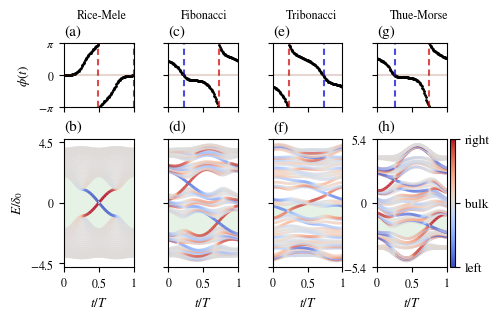

In [8]:
fill[0] = 50//2


fig, ax= plt.subplots(2,4, figsize=(4.7, 3), gridspec_kw={'height_ratios': [1, 2]})

fz = 9.5
ft = 8.5
ftt = 11

for i in range(4):
    ax[0,i].scatter(T, ph[i], c="k", s=1)
    ax[0,i].axvline(T[np.argmax(ph[i])], c=(0.8,0,0,0.7), ls="--", dashes=(3, 2))
    ax[0,i].axvline(T[np.argmin(np.abs(ph[i]))], c=(0,0,0.8,0.7), ls="--", dashes=(3, 2))
    ax[0,i].tick_params(axis='x', labelbottom=False)

    
for axs in ax[0,:]:
    axs.axhline(0, c=(0.5,0.2,0.1,0.2))
    axs.set_xlim([0, 2*np.pi])
    axs.set_ylim([-(np.pi), (np.pi)])
    axs.set_yticks(np.linspace(-np.pi, np.pi ,3),['$-\pi$','$0$','$\pi$'], fontsize = ft)
    axs.set_xticks(np.linspace(0, 2*np.pi ,3),['$0$', "$\pi$",'$2\pi$'], fontsize = ft)
    
ax[0,0].set_ylabel('$\\phi(t)$', fontsize=fz)
for i in range(3):
    ax[0,i+1].tick_params(axis='y', labelleft=False)
    

for i in range(4):
    norm = plt.Normalize(0,np.max(r[i]))

    lc1 = LineCollection(segments[i], cmap = cm.coolwarm,norm=norm)
    lc1.set_array(color[i])
    lc1.set_linewidth(2)
    line = ax[1,i].add_collection(lc1)
    
#     ax[1,i].set_box_aspect(2)
        
    ax[1,i].set_xlim([0, 2*np.pi])
    ax[1,i].set_xticks(np.linspace(0, 2*np.pi ,3),['$0$', "$0.5$",'$1$'], fontsize = ft)
    ax[1,i].set_xlabel('$t/T$', fontsize=fz)
    
    j=2
    if i<3:
        ax[1,i].set_ylim([1.1*np.min(spectrum[j]),1.1*np.max(spectrum[j])]);
        ax[1,i].set_yticks(np.linspace(1.1*np.min(spectrum[j]), 1.1*np.max(spectrum[j]) ,3))
    else:
        ax[1,i].set_ylim([1.1*np.min(spectrum[i]),1.1*np.max(spectrum[i])]);
        stringenergy = ['${:.1f}$'.format(1.1*np.min(spectrum[i])),'$0$','${:.1f}$'.format(1.1*np.max(spectrum[i]))]
        ax[1,i].set_yticks(np.linspace(1.1*np.min(spectrum[i]), 1.1*np.max(spectrum[i]) ,3), stringenergy, fontsize = ft)

stringenergy = ['${:.1f}$'.format(1.1*np.min(spectrum[0])),'$0$','${:.1f}$'.format(1.1*np.max(spectrum[0]))]
for i in range(2):
        ax[1,i+1].tick_params(axis='y', labelleft=False)
ax[1,0].set_yticks(np.linspace(1.1*np.min(spectrum[0]), 1.1*np.max(spectrum[0]) ,3), stringenergy, fontsize = ft)
ax[1,0].set_ylabel('$E/\\delta_0$', fontsize=fz)

for q in range(4):
    ax[1,q].fill_between(T, spectrum[q][fill[q]-2,:], spectrum[q][fill[q]+1,:], where=(spectrum[q][fill[q]+1,:] > spectrum[q][fill[q]-2,:]), facecolor='green', alpha=0.1)

plt.tight_layout(w_pad = -0.2, h_pad = 1.5)


modelstart = ["Rice-Mele", "Fibonacci", "Tribonacci", "Thue-Morse"]
for q in range(4):
    poss = ax[0,0].get_position()
    ax[0,q].text(poss.x0+1, poss.y0+4.9, modelstart[q], fontsize=ft);

pos = ax[1,3].get_position()
cbar_ax = fig.add_axes([pos.x0+1.05*pos.width, pos.y0, 0.01, pos.height])
cbar = plt.colorbar(line, cax=cbar_ax, ticks = [0, np.max(r[3])/2, np.max(r[3])])
cbar.set_ticklabels(['left','bulk','right'], fontsize = fz)

# Define variable names for the keys of dict
variables = ['a', 'c', 'e', 'g', 'b', 'd', 'f', 'h']

# Create a dictionary using a loop
dicts = {}
for i, variable in enumerate(variables):
    key = f"({variable})"
    if i<4:
        value = ax[0, i]
    else:
        value= ax[1, i%4]
    dicts[key] = value

for key, axs in dicts.items():
            axs.set_title(key, loc='left', fontsize=ftt)

# plt.savefig("AperiodicBott_hvsD_TraversingModes_Good.png", dpi=600, bbox_inches="tight")

## Calculating the dielectric response / polarization susceptibility of the SSH chain

In [106]:
# SSH dielectric response


F=100 #size
A= [-0.5,0.5] #dimerization
T=np.zeros([2,F])
Ho=np.zeros([2,F,F])
for i in range(len(A)):
    T[i,:]=np.asarray([-(1+A[i]*(-1)**j) for j in range(F)])
    Ho[i,:,:]=np.diag(T[i,:-1,],1)+np.diag(T[i,:-1,],-1)


LE=[0] #range of Fermi energies
l=len(LE)
kk=500 #step size in electric field strength 
Efs=np.linspace(-0.01,0.01,kk) #electric field strength

PP=[]
for i in range(len(A)):
#     polsusc(Ho[:,:,0], Efs, EfermiTM, Ns, Nc)[1]
    P0=polsusc(Ho[i,:,:], Efs, LE, 2, 50)[1] 
    PP.append(P0)
    
PP=np.asarray(PP)


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 676.52it/s]


In [107]:
FS=[100,100]
EE=[]
for i in range(len(A)):
    EE.append(getspect(Ho[i,:,:])[0])

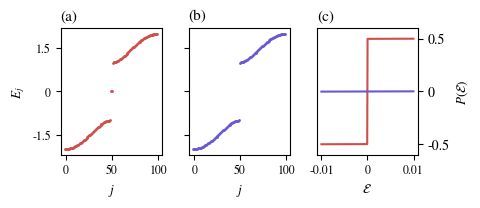

In [112]:
fig, ax=plt.subplots(1,3, figsize=(4.9, 2))
fz = 9.5
ft = 8.5
ftt = 11

clrs = ["#ce4f4aff", "#6859d1ff"]


ax[0].scatter(np.arange(FS[0]),EE[0], s=1, color=clrs[0]);
ax[1].scatter(np.arange(FS[1]),EE[1], s=1, color=clrs[1]);
for i in range(2):
    ax[i].set_xlabel("$j$", fontsize=fz);
    ax[i].set_yticks(ticks=[-1.5, 0, 1.5], labels=["-1.5", "0", "1.5"], fontsize = ft);
    ax[i].set_xticks(ticks=[1, FS[i]/2, FS[i]], labels=["0", "{:d}".format(int(FS[i]/2)), "{:d}".format(int(FS[i]))], fontsize=ft);
ax[0].set_ylabel("$E_j$", fontsize=fz);
ax[1].yaxis.set_tick_params(labelleft=False)

ax[2].plot(Efs[:-1],PP[0,:-1], color=clrs[0], label="Topological")
ax[2].plot(Efs[:-1],PP[1,:-1], color=clrs[1], label="Trivial")

# ax[2].legend(loc='upper left', fontsize=6);
ax[2].set_ylim(-0.6,0.6);
ax[2].set_yticks(ticks = [-0.5,0,0.5], labels = ["-0.5", "0", "0.5"]);
ax[2].set_xticks(ticks=[-0.01, 0, 0.01], labels=["-0.01", "0", "0.01"], fontsize = ft);
ax[2].set_xlabel("$\\mathcal{E}$", fontsize=fz);
ax[2].set_ylabel("$P(\\mathcal{E})$", fontsize=fz);
ax[2].yaxis.set_label_position("right")
ax[2].yaxis.tick_right()

# for axs in ax:
#     axs.set_box_aspect(1.5)

plt.tight_layout()

dicts={"(a)": ax[0], "(b)": ax[1], "(c)": ax[2]}

for key, axs in dicts.items():
    axs.set_title(key, loc='left', 
            fontsize = ftt)
    
# plt.tight_layout()



# plt.savefig("SSH_Polarization_Responses_Good.pdf", dpi = 300, bbox_inches="tight")

## Calculating the phase diagram of inversion symmetric realizations of the aperiodic models

In [17]:
def Berryphase(H,N,fill,K):
    """TT: hopping steps,  K: momentum steps, fill: filling, Tf: Hopping word. Hamiltonian H[k,:,:]"""
    
    kk=K
    NTM = N
    
    ETM = np.zeros([kk, NTM], dtype=np.complex128)
    vrTM = np.zeros([kk, NTM, NTM], dtype=np.complex128)

    for i in range(kk):

        vrTM[i,:,:] = getspect(H[i,:,:])[1]
            
    psif=vrTM[:,:,:fill]

    #Periodic gauge fixing
    for j in range(NTM):
        psif[kk-1,j,:] = np.exp(-1j*2*np.pi*(j+1))*psif[0,j,:]

  
    M = np.diag(np.ones(fill))
    for j in range(kk-1):
        S = psif[j,:,:].T.conj()@ psif[j+1,:,:]
        M =  M @ S 

    ph = -np.sum(np.log(np.linalg.eigvals(M))).imag
        
    return ph

In [18]:
# Fibonacci palindrome 


kk=50
k=np.linspace(0, 2*np.pi, kk)

N = 9
F = Fibonr(N)
NF = F-2
fill = Fibonr(N-3) - 1

rr = 50
v1 = np.linspace(-2, 2, rr)

tt = 50
v2 = np.linspace(-2,2,tt)

T = 1

phifib = np.zeros([rr,tt])

for i in tqdm(range(rr)):
    for j in range(tt):
        hfib = np.zeros([kk,NF,NF], dtype = np.complex128)
        tfib = bihopping(FiboWord(N), F, v1[i], v2[j])
        for q in range(kk):
            
            hfib[q,:,:] = np.diag(T*np.ones(NF)[:-1],1) + np.diag(T*np.ones(NF)[:-1],-1) + np.diag(tfib[:-2])
            hfib[q,0,NF-1] = T*np.exp(1j*k[q])
            hfib[q,NF-1,0] = T*np.exp(-1j*k[q])
            
        
        phifib[i,j] = Berryphase(hfib, NF, fill, kk)


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [04:32<00:00,  5.45s/it]


In [19]:
# Tribonacci palindrome 

kk=50
k=np.linspace(0, 2*np.pi, kk)

N = 8
F = Tribonr(N)
En = 0.5*(Tribonr(N) - Tribonr(N-2)+3)
NF = int(F-En)
fill = Tribonr(N-2) - 2

rr = 50
v1 = np.linspace(-2, 2, rr)

tt = 50
v2 = np.linspace(-2, 2, tt)

phitrib = np.zeros([rr, tt])


for i in tqdm(range(rr)):
    for j in range(tt):
        htrib = np.zeros([kk,NF,NF], dtype = np.complex128)
        ttrib = trihopping(TriboWord(N), F, 0, v1[i], v2[j])
        for q in range(kk):
            
            htrib[q,:,:] = np.diag(T*np.ones(NF)[:-1],1) + np.diag(T*np.ones(NF)[:-1],-1) + np.diag(ttrib[:-int(En)])
            htrib[q,0,NF-1] = T*np.exp(1j*k[q])
            htrib[q,NF-1,0] = T*np.exp(-1j*k[q])
            
        
        phitrib[i,j] = Berryphase(htrib, NF, fill, kk)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [04:01<00:00,  4.83s/it]


In [20]:
#Thue Morse simplified

kk=50
k=np.linspace(0, 2*np.pi, kk)

ntm = 6
NF = 2**ntm

rr = 50
v1 = np.linspace(-2, 2, rr)

tt = 50
v2 = np.linspace(-2, 2,tt)

T = 2

phiTM = np.zeros([rr,tt])

fill = NF//3


for i in tqdm(range(rr)):
    for j in range(tt):
        hntm = np.zeros([kk,NF,NF], dtype = np.complex128)
        tntm = bihopping(TMWord(ntm), NF, v1[i], v2[j])
        for q in range(kk):
            
            hntm[q,:,:] = np.diag(T*np.ones(NF)[:-1],1) + np.diag(T*np.ones(NF)[:-1],-1) + np.diag(tntm)
            hntm[q,0,NF-1] = T*np.exp(1j*k[q])
            hntm[q,NF-1,0] = T*np.exp(-1j*k[q])
            
        
        phiTM[i,j] = Berryphase(hntm, NF, fill, kk)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [07:29<00:00,  9.00s/it]


## Plotting the phase diagrams

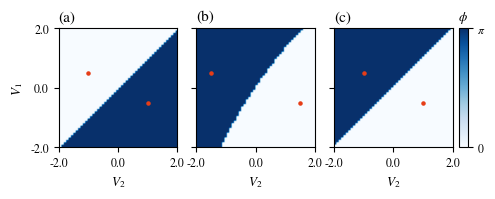

In [21]:
phi = [phifib, phitrib, phiTM]

v1 = np.linspace(-2,2,50)
v2 = np.linspace(-2,2,50)
xmn, xmx, ymn, ymx= np.min(v2), np.max(v2), np.min(v1), np.max(v1)

fz, ft, ftt = 9.5, 8.5, 11

fig, ax = plt.subplots(1, 3, figsize = (4.5,1.5))  # Create figure and axes

for i in range(3):
    cax = ax[i].imshow(np.abs(phi[i]), cmap="Blues", extent=[xmn, xmx, ymn, ymx], origin='lower')

ax[0].scatter(np.array([1, -1]), np.array([-0.5, 0.5]), s = 5, c = "#e63d17")
ax[1].scatter(np.array([1.5, -1.5]), np.array([-0.5, 0.5]), s = 5, c = "#e63d17")
ax[2].scatter(np.array([1, -1]), np.array([-0.5, 0.5]), s = 5, c = "#e63d17")

xtik = np.linspace(xmn, xmx, 3)
xtiklab = [f"{xtik[i]:.1f}" for i in range(len(xtik))]

ytik = np.linspace(ymn, ymx, 3)
ytiklab = [f"{ytik[i]:.1f}" for i in range(len(ytik))]

for axs in ax:
    axs.set_xticks(xtik, xtiklab, fontsize = ft);
    axs.set_xlabel("$V_2$", fontsize =fz)
    axs.set_yticks(ytik, ytiklab, fontsize = ft);
    
    
for axs in ax[1:]:
    axs.yaxis.set_tick_params(labelleft=False)
    
ax[0].set_ylabel("$V_1$", fontsize =fz)    

plt.tight_layout(pad = -0.15)


pos = ax[2].get_position()
cbar_ax = fig.add_axes([pos.x0+1.05*pos.width, pos.y0, 0.02, pos.height])
cbar = plt.colorbar(cax, cax=cbar_ax, ticks = [0, np.pi])
cbar.set_ticklabels(['0', "$\pi$"], fontsize = ft)
cbar.ax.set_title("$\phi$", fontsize = fz)

variables = ["a", "b", "c"]

dicts = {}
for i, variable in enumerate(variables):
    key = f"({variable})"
    value = ax[i]        
    dicts[key] = value
    
for key, axs in dicts.items():
            axs.set_title(key, loc='left', fontsize=ftt)

# filetype=".{}".format(input("Please specify file format to save (without dot): "))
# plt.savefig("Aperiodic_Berry_Phases" + filetype, dpi=600, bbox_inches="tight") 

## Calculating the polarization susceptibilty of the three aperiodic models in their inversion-symmetric nontrivial phase

In [7]:
# # Thue Morse Yoshi RM  Polarization susceptibility with periodic approximation

D, d0, h0, n = 2, 1, 1, 6,
NTM, NcTM= 2**n, 1;
# TT = 301

tpi = 4.71238898038469
t0 = 1.5707963267948968

d = [d0*np.cos(tpi), d0*np.cos(t0)]
h = [h0*np.sin(tpi), h0*np.sin(t0)]

N = NcTM*NTM

ETM = np.zeros([N])
vrTM = np.zeros([N,N], dtype=np.complex128)

Tf = bihopping(TMWord(n),NTM,1, -0.5)

H = np.zeros([NcTM*NTM,NcTM*NTM,2])

for w in range(2):
    t = D-Tf*d[w]
    u = -Tf*h[w]
    
    for c in range(NcTM):
        H[NTM*c:NTM*(c+1),NTM*c:NTM*(c+1),w] = np.diag(t[0:NTM-1],1)+np.diag(t[0:NTM-1],-1)+np.diag(u)
#         H[NTM:,NTM:,w] = np.diag(t[0:NTM-1],1)+np.diag(t[0:NTM-1],-1)+np.diag(u)
        if c < NcTM-1:
            H[(c+1)*NTM-1,(c+1)*NTM,w] = t[NTM-1]
            H[(c+1)*NTM,(c+1)*NTM-1,w] = t[NTM-1]

ETM1, vrTM1 = getspect(H[:,:,0])
ETM2, vrTM2 = getspect(H[:,:,1])


In [67]:
EfermiTM=[ETM1[N//3-1], ETM2[N//3-1]]

EFA = 0.0025
kk = 500
Efs=np.linspace(-EFA,EFA,kk)

P0TM1=polsusc(H[:,:,0], Efs, EfermiTM[0], NTM, NcTM)[1]
P0TM2=polsusc(H[:,:,1], Efs, EfermiTM[1], NTM, NcTM)[1]

P0TM = [P0TM1, P0TM2]

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1805.78it/s]


In [68]:
 # # Fibonacci Yoshi RM  Polarization susceptibility with periodic approximation

D, d0, h0, n = 2, 1, 1, 9,
NFib, NcF= Fibonr(n), 2;
# TT = 301
# T = np.linspace(0, 2*np.pi,TT)

tpi = 4.523893421169302
t0 = 1.3823007675795091

d = [d0*np.cos(tpi), d0*np.cos(t0)]
h = [h0*np.sin(tpi), h0*np.sin(t0)]

N = NcF*NFib

Tf = bihopping(FiboWord(n), NFib,1,-0.5)

H = np.zeros([NcF*NFib,NcF*NFib,2])

for w in range(2):
    t = D-Tf*d[w]
    u = -Tf*h[w]
    
    for c in range(NcF):
        H[NFib*c:NFib*(c+1),NFib*c:NFib*(c+1),w] = np.diag(t[0:NFib-1],1)+np.diag(t[0:NFib-1],-1)+np.diag(u)
#         H[NTM:,NTM:,w] = np.diag(t[0:NTM-1],1)+np.diag(t[0:NTM-1],-1)+np.diag(u)
        if c < NcF-1:
            H[(c+1)*NFib-1,(c+1)*NFib,w] = t[NFib-1]
            H[(c+1)*NFib,(c+1)*NFib-1,w] = t[NFib-1]

EFib1, vrFib1 = getspect(H[:,:,0])
EFib2, vrFib2 = getspect(H[:,:,1])

fill = Fibonr(n-2)


In [69]:
EfermiFib=[EFib1[NcF*fill-1], EFib2[NcF*fill-1]]
# EfermiFib=[getspect(H[:,:,0])[0][NcF*fill-1], getspect(H[:,:,1])[0][NcF*fill-1]]

EFA = 0.0025
kk = 500
Efs=np.linspace(-EFA,EFA,kk)

P0Fib1=polsusc(H[:,:,0], Efs, EfermiFib[0], NFib, NcF)[1]
P0Fib2=polsusc(H[:,:,1], Efs, EfermiFib[1], NFib, NcF)[1]

P0Fib = [P0Fib1, P0Fib2]

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 478.65it/s]


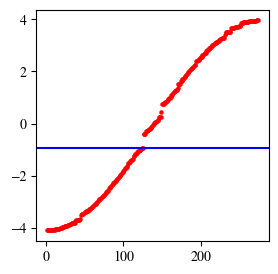

In [70]:
# # Tribonacci Yoshi RM  Polarization susceptibility with periodic approximation

D, d0, h0, n = 2, 1, 1, 10,
NTrib, NcT= Tribonr(n), 1;
# TT = 301
# T = np.linspace(0, 2*np.pi,TT)

t0 = 4.523893421169302
tpi = 1.3823007675795091

d = [d0*np.cos(tpi), d0*np.cos(t0)]
h = [h0*np.sin(tpi), h0*np.sin(t0)]

N = NcT*NTrib

Tf = trihopping(TriboWord(n),NTrib,-1,-0.3,0.3)

H = np.zeros([NcT*NTrib,NcT*NTrib,2])

for w in range(2):
    t = D-Tf*d[w]
    u = -Tf*h[w]
    
    for c in range(NcT):
        H[NTrib*c:NTrib*(c+1),NTrib*c:NTrib*(c+1),w] = np.diag(t[0:NTrib-1],1)+np.diag(t[0:NTrib-1],-1)+np.diag(u)
        if c < NcT-1:
            H[(c+1)*NTrib-1,(c+1)*NTrib,w] = t[NTrib-1]
            H[(c+1)*NTrib,(c+1)*NTrib-1,w] = t[NTrib-1]

ETrib1, vrTrib1 = getspect(H[:,:,0])
ETrib2, vrTrib2 = getspect(H[:,:,1])

fill = Tribonr(n-3)+Tribonr(n-2)


In [71]:
EfermiTrib=[ETrib1[NcT*fill-1], ETrib2[NcT*fill-1]]

EFA = 0.0025
kk = 500
Efs=np.linspace(-EFA,EFA,kk)

P0Trib1=polsusc(H[:,:,0], Efs, EfermiTrib[0], NTrib, NcT)[1]
P0Trib2=polsusc(H[:,:,1], Efs, EfermiTrib[1], NTrib, NcT)[1]

P0Trib = [P0Trib1, P0Trib2]

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:24<00:00, 20.25it/s]


In [72]:
Nc = [NcF, NcT, NcTM]

N = [NFib*Nc[0], NTrib*Nc[1], NTM*Nc[2]]

E = [EFib1, ETrib1, ETM1]

nfib, ntrib, ntm = 9, 10, 6

fill = [Fibonr(nfib-2), Tribonr(ntrib-3) + Tribonr(ntrib-2), NTM//3]

P0 = [P0Fib, P0Trib, P0TM]

## Plotting all the polarization susceptibility results, together with the spectra marking the inversion-symmetric edge states 

Please specify file format to save (without dot): pdf
Please specify which system this is: PolRespsGood


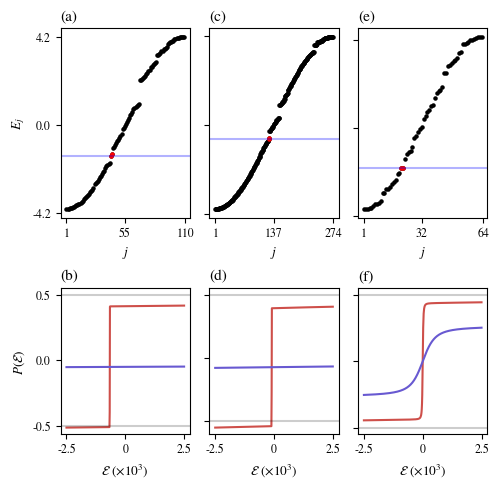

In [86]:
fig, ax= plt.subplots(2,3, figsize=(4.8, 4.5), gridspec_kw={'height_ratios': [1.3, 1]})

fz = 9.5
ft = 8.5
ftt = 11

clrs = ["#ce4f4aff", "#6859d1ff"]

for p in range(3):
    
    ax[0,p].scatter(np.arange(1,N[p]+1), E[p], s=5, c="k");
    ax[0,p].scatter(np.arange(Nc[p]*fill[p], Nc[p]*fill[p]+2), E[p][Nc[p]*fill[p]-1:Nc[p]*fill[p]+1], s=5, c="r");
    ax[0,p].axhline(E[p][Nc[p]*fill[p]-1], c="b", alpha=0.3);
    
    ax[0,p].set_xticks(ticks=[1, N[p]//2, N[p]+1], labels=["1",f"{N[p]//2}", f"{N[p]}"], fontsize=ft);
#     ax[0,p].xaxis.set_tick_params(labelbottom=False)
    ax[0,p].set_xlabel("$j$", fontsize=fz);

    for tt in range(2):
#         kk=len(P0[p][tt])
#         Efs = np.linspace(-EFA,EFA,kk)
        ax[1,p].plot(Efs[:-1],P0[p][tt][:-1], color= clrs[tt])
    
        ax[1,p].axhline(-0.5, c="k", alpha=0.1)
        ax[1,p].axhline(0.5, c="k", alpha=0.1)

        ax[1,p].set_xticks(ticks=[np.min(Efs), 0, np.max(Efs)], labels=[f"{np.min(Efs)*1000:.1f}", "0", f"{np.max(Efs)*1000:.1f}"], fontsize=ft);
        ax[1,p].set_xlabel("$\\mathcal{E} \ (\\times 10^{3})$", fontsize=fz);

# pmax=np.max([np.max(arr) for arr in P0])
ax[1,0].set_ylabel("$P(\\mathcal{E})$", fontsize=fz);
ax[0,0].set_ylabel("$E_j$", fontsize=fz);

tik = [-0.5, 0, 0.5]
tiklab = [f"{tik[i]:.1f}" for i in range(len(tik))]
ax[1,0].set_yticks(ticks = tik, labels = tiklab, fontsize=ft);
for axs in ax[1,1:]:
    axs.set_yticks(ticks = tik, labels = tiklab, fontsize=ft);
    axs.yaxis.set_tick_params(labelleft=False)
    
tik = [-np.max(E[0]), 0, np.max(E[0])]
tiklab = [f"{tik[i]:.1f}" for i in range(len(tik))]
ax[0,0].set_yticks(ticks = tik, labels = tiklab, fontsize=ft);
for axs in ax[0,1:]:
    axs.set_yticks(ticks = tik, labels = tiklab, fontsize=ft);
    axs.yaxis.set_tick_params(labelleft=False)

# # for axs in ax:
# #     axs.set_box_aspect(1.5)

plt.tight_layout(pad=0, h_pad=2, w_pad=0.7)

# Define variable names for the keys of dict
variables = ['a', 'c', 'e', "b", "d", "f"]

# Create a dictionary using a loop

dicts = {}
for i, variable in enumerate(variables):
    key = f"({variable})"
    if i<3:
        value = ax[0, i]
    else:
        value= ax[1, i%3]
        
    dicts[key] = value
    
for key, axs in dicts.items():
            axs.set_title(key, loc='left', fontsize=ftt)


# filetype=".{}".format(input("Please specify file format to save (without dot): "))
# plt.savefig("{}_Polarization_Responses".format(input("Please specify which system this is: "))+filetype, dpi=600, bbox_inches="tight") 



## Calculating the Chern number and the Bott-index of the Rice-mele model 

In [8]:
#Yoshi RM- Chern number calcuations

d= -1;
rs=12
D=np.linspace(-2,2,rs);
h=np.linspace(-2,2,rs);
Chern=np.zeros([rs,rs])
for j in tqdm(range(rs)):
    for i in range(rs):
        f = lambda x, y: 1/(2*np.pi)*((np.sqrt(2)*h[i]*(-D[j] + d*np.cos(y))*(d*(-1 + np.cos(x)) + D[j]*(1 + np.cos(x))*np.cos(y)))/(h[i]**2 + 2*d**2 + 4*D[j]**2 - 
   2*d**2*np.cos(x) + 
   4*D[j]**2*np.cos(x) - (h[i]**2 - 2*d**2 + 2*d**2*np.cos(x))*np.cos(2*y))**(3/2))
        Chern[i,j] = intg.dblquad(f, -np.pi, np.pi, -np.pi, np.pi)[0]


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:03<00:00,  5.30s/it]


In [9]:
# Bott index phase diagram RM model

nrp, nrt = 50, 50

# D, h0, d0 = 2, 1, 1
# h0, d0 = 1, 1
d0 = 1
nrm, nrn = 10, 10
D = np.linspace(-2, 2, nrm)
h0 = np.linspace(-2, 2, nrn)

T = np.linspace(0, 1, nrt) #Time

# dx=np.abs(k[1]-k[2])
# dt=np.abs(t[1]-t[2])


BidxRM = np.zeros([nrm, nrn], dtype=np.complex128)


for q in tqdm(range(nrm)):
    for l in range(nrn):
        
        N=50
        
        d = d0*np.cos(2*np.pi*T)
        h = h0[l]*np.sin(2*np.pi*T)

        E = np.zeros([nrt,N], dtype=np.complex128)
        vr = np.zeros([nrt,N,N], dtype=np.complex128)


        for i in range(nrt):

            t=np.asarray([D[q]-(-1)**(j+1)*d[i] for j in range(N)])  
            u=np.asarray([-(-1)**(j+1)*h[i] for j in range(N)])

            H=np.diag(t[0:N-1],1)+np.diag(t[0:N-1],-1)+np.diag(u)
            H[0,N-1]=t[N-1]
            H[N-1,0]=t[N-1]
            E[i,:], vr[i,:,:]=getspect(H)
        
        BidxRM[q,l] = currentpumped(vr,E,0.5,1)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.20it/s]


## Plotting the Bott and Chern number 

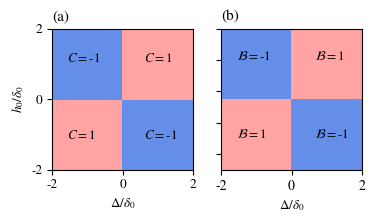

In [11]:
# RM Chern and Bott indices Plot

fig, ax= plt.subplots(1,2, figsize=(4,2))

clrs = ["#ffa3a3ff", "#648ee8ff"]

clrmap = LinearSegmentedColormap.from_list("CustomMap", [clrs[0], "white", clrs[1]])


ax[0].imshow(Chern.real, origin='lower', extent=[0, rs-1, 0, rs-1], cmap=clrmap, alpha=1)

fz, ft, ftt = 9.5, 8.5, 11

# Reverse the y-axis
plt.gca().invert_yaxis()
sc=rs/10
DD=np.linspace(-2,2,rs);
hh=np.linspace(-2,2,rs);
ax[0].text(1*sc,2*sc,"$C=$%.0f" %(Chern[int(np.where(hh>0)[0][0]), int(np.where(DD<0)[0][0])].real), fontsize=fz);
ax[0].text(1*sc,7*sc,"$C=$%.0f" %(Chern[int(np.where(hh<0)[0][0]), int(np.where(DD<0)[0][0])].real), fontsize=fz);
ax[0].text(6*sc,2*sc,"$C=$%.0f" %(Chern[int(np.where(hh>0)[0][0]), int(np.where(DD>0)[0][0])].real), fontsize=fz);
ax[0].text(6*sc,7*sc,"$C=$%.0f" %(Chern[int(np.where(hh<0)[0][0]), int(np.where(DD>0)[0][0])].real), fontsize=fz);

ax[0].set_xticks([0,rs/2-0.5,rs-1], ["-2", "0", "2"], fontsize = fz)
ax[0].set_yticks([0,rs/2-0.5,rs-1], ["-2", "0", "2"], fontsize = fz)
ax[0].set_ylabel('$h_0/\\delta_0$', fontsize=fz)
ax[0].set_xlabel('$\\Delta/\\delta_0$', fontsize=fz)


ax[1].imshow(BidxRM.real, origin='lower', extent=[0, nrm-1, 0, nrn-1], cmap=clrmap, alpha=1)

# Reverse the y-axis
plt.gca().invert_yaxis()
sc=nrm/10
DD=np.linspace(-2,2,nrm)
hh=np.linspace(-2,2,nrm)

ax[1].text(1*sc,2*sc,"$\\mathcal{B}=$%.0f" %(BidxRM[int(np.where(hh>0)[0][0]), int(np.where(DD<0)[0][0])].real), fontsize=fz);
ax[1].text(1*sc,7*sc,"$\\mathcal{B}=$%.0f" %(BidxRM[int(np.where(hh<0)[0][0]), int(np.where(DD<0)[0][0])].real), fontsize=fz);
ax[1].text(6*sc,2*sc,"$\\mathcal{B}=$%.0f" %(BidxRM[int(np.where(hh>0)[0][0]), int(np.where(DD>0)[0][0])].real), fontsize=fz);
ax[1].text(6*sc,7*sc,"$\\mathcal{B}=$%.0f" %(BidxRM[int(np.where(hh<0)[0][0]), int(np.where(DD>0)[0][0])].real), fontsize=fz);

ax[1].set_xticks([0,nrm/2-0.5,nrm-1],[-2, 0, 2])
ax[1].tick_params(axis='y', labelleft=False)
ax[1].set_xlabel('$\\Delta/\\delta_0$', fontsize=fz)


# Define variable names for the keys of dict
dicts = {'(a)': ax[0], '(b)': ax[1]}

for key, axs in dicts.items():
    axs.set_title(key, loc='left', fontsize=ftt)

# plt.savefig("ChernvsBott_RMGood.pdf", dpi = 300, bbox_inches="tight")

## Calculating the dependence of the Berry phase and spectral evolution on the unit cell choice of the periodic approximants of the aperiodic models

In [2]:
def Bph4unitcells(N, Thop, fill, D=2, d0=1, h0=1, t=101):
    
    # Calculating the Berry phases as functions of time and dependence on unit cell for Fibonacci model. 

    TT = t
    T = np.linspace(0, 2*np.pi,TT)

    d = d0*np.cos(T)
    h = h0*np.sin(T)

    Tf = Thop

    hops = Tf

    kk=50
    k=np.linspace(0, 2*np.pi, kk)

    H_ext = np.zeros([TT, 2*N, 2*N], dtype = np.complex128)
    t_ext = np.zeros([TT, 2*N])
    u_ext = np.zeros([TT, 2*N])


    for tt in range(TT):
        t = D-hops*d[tt]
        u = -hops*h[tt]

        H = np.diag(t[0:N-1],1)+np.diag(t[0:N-1],-1)+np.diag(u)
        H[0,N-1] = t[N-1]
        H[N-1,0] = t[N-1]

        H_ext[tt, :N, :N] = H
        H_ext[tt, N:, :N] = H
        H_ext[tt, :N, N:] = H
        H_ext[tt, N:, N:] = H

        t_ext[tt,:] = np.append(t,t)
        u_ext[tt,:] = np.append(u,u)
        
    # Playing with four different unit cells:

    c = [0, N//4, N//2, 3*N//4] #has to be smaller than N

    H1 = np.zeros([TT, kk, N, N], dtype=np.complex128)
    H2 = np.zeros([TT, kk, N, N], dtype=np.complex128)
    H3 = np.zeros([TT, kk, N, N], dtype=np.complex128)
    H4 = np.zeros([TT, kk, N, N], dtype=np.complex128)

    HH = [H1, H2, H3, H4]

    for q in range(4):
        for tt in range(TT):
            for i in range(kk):
                HH[q][tt, i, :, :] = H_ext[tt, c[q]:(c[q]+N), c[q]:(c[q]+N)]
                HH[q][tt, i, 0, N-1] = t_ext[tt, c[q]+N]*np.exp(1j*k[i])
                HH[q][tt, i, N-1, 0] = t_ext[tt, c[q]+N]*np.exp(-1j*k[i])
    
    ph = np.zeros([4,TT])

    for q in range(4):
        ph[q,:] = TDBerryphase(HH[q],fill,TT,kk)
        
        
    E1 = np.zeros([TT, N], dtype=np.complex128)
    E2 = np.zeros([TT, N], dtype=np.complex128)
    E3 = np.zeros([TT, N], dtype=np.complex128)
    E4 = np.zeros([TT, N], dtype=np.complex128)

    E = [E1, E2, E3, E4]

    vr1 = np.zeros([TT, N, N], dtype=np.complex128)
    vr2 = np.zeros([TT, N, N], dtype=np.complex128)
    vr3 = np.zeros([TT, N, N], dtype=np.complex128)
    vr4 = np.zeros([TT, N, N], dtype=np.complex128)

    vr = [vr1, vr2, vr3, vr4]

    for q in tqdm(range(4)):      
        for tt in range(TT):

            h = HH[q][tt,0,:,:]

            h[0, N-1] = 0 #making Ham OBC
            h[N-1, 0] = 0 #making Ham OBC

            E[q][tt,:], vr[q][tt,:,:] = getspect(h)
            
    color1, segments1, r1, spectrum1 = segcolor(E[0], vr[0], N, TT)
    color2, segments2, r2, spectrum2 = segcolor(E[1], vr[1], N, TT)
    color3, segments3, r3, spectrum3 = segcolor(E[2], vr[2], N, TT)
    color4, segments4, r4, spectrum4 = segcolor(E[3], vr[3], N, TT)
    
    color = [color1, color2, color3, color4]
    segments = [segments1, segments2, segments3, segments4]
    r = [r1, r2, r3, r4]
    spectrum = [spectrum1, spectrum2, spectrum3, spectrum4]
        

    return (ph, r, segments, color, spectrum)

In [6]:
# Fibonacci case

n = 9
N = Fibonr(n);
Tf = bihopping(FiboWord(n),N,1,-0.5)
TT = 101
T = np.linspace(0, 2*np.pi,TT)
fill = Fibonr(n-2)

ph, r, segments, color, spectrum = Bph4unitcells(N, Tf, fill, D=2, d0=1, h0=1, t=101)

100%|██████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 6751.53it/s]


In [ ]:
# Tribonacci case

n = 7
N = Tribonr(n);
Tf = trihopping(TriboWord(n),N,-1, -0.3, 0.3)
TT = 101
T = np.linspace(0, 2*np.pi,TT)
fill = Tribonr(n-3)+Tribonr(n-2)

ph, r, segments, color, spectrum = Bph4unitcells(N, Tf, fill, D=2, d0=1, h0=1, t=101)

In [ ]:
# Thue Morse case

n = 6
N = len(TMWord(n))
Tf = bihopping(TMWord(n),N, 1, -0.5)
TT = 101
T = np.linspace(0, 2*np.pi,TT)
fill = N//3

ph, r, segments, color, spectrum = Bph4unitcells(N, Tf, fill, D=2, d0=1, h0=1, t=101)

## Plotting the results for the unit-cell dependence

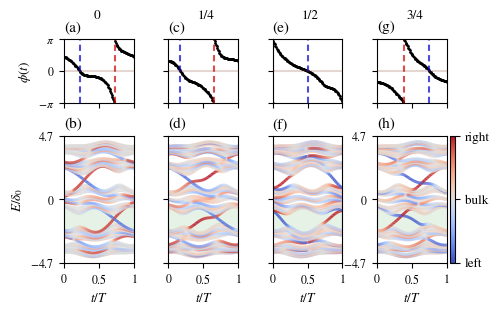

In [7]:
fig, ax= plt.subplots(2,4, figsize=(4.7, 3), gridspec_kw={'height_ratios': [1, 2]})

fz, fzz, ftt = 9.5, 8.5, 11

for i in range(4):
    ax[0,i].scatter(T, ph[i], c="k", s=1)
    ax[0,i].axvline(T[np.argmax(ph[i])], c=(0.8,0,0,0.7), ls="--", dashes=(3, 2))
    ax[0,i].axvline(T[np.argmin(np.abs(ph[i]))], c=(0,0,0.8,0.7), ls="--", dashes=(3, 2))
#     ax[0,i].set_xlabel('$t/T$', fontsize=fz)
    ax[0,i].tick_params(axis='x', labelbottom=False)

    
for axs in ax[0,:]:
    axs.axhline(0, c=(0.5,0.2,0.1,0.2))
    axs.set_xlim([0, 2*np.pi])
    axs.set_ylim([-(np.pi), (np.pi)])
    axs.set_yticks(np.linspace(-np.pi, np.pi ,3),['$-\pi$','$0$','$\pi$'], fontsize = fzz)
    axs.set_xticks(np.linspace(0, 2*np.pi ,3),['$0$', "$0.5$",'$1$'], fontsize = fzz)
    
ax[0,0].set_ylabel('$\\phi(t)$', fontsize=fz)
for i in range(3):
    ax[0,i+1].tick_params(axis='y', labelleft=False)
    

for i in range(4):
    norm = plt.Normalize(0,np.max(r[i]))

    lc1 = LineCollection(segments[i], cmap = cm.coolwarm,norm=norm)
    lc1.set_array(color[i])
    lc1.set_linewidth(2)
    line = ax[1,i].add_collection(lc1)
    
#     ax[1,i].set_box_aspect(2)
        
    ax[1,i].set_xlim([0, 2*np.pi])
    ax[1,i].set_xticks(np.linspace(0, 2*np.pi ,3),['$0$', "$0.5$",'$1$'], fontsize = fzz)
    ax[1,i].set_xlabel('$t/T$', fontsize=fz)
    
    j=2
    if i<3:
        ax[1,i].set_ylim([1.1*np.min(spectrum[j]),1.1*np.max(spectrum[j])]);
        ax[1,i].set_yticks(np.linspace(1.1*np.min(spectrum[j]), 1.1*np.max(spectrum[j]) ,3))
    else:
        ax[1,i].set_ylim([1.1*np.min(spectrum[i]),1.1*np.max(spectrum[i])]);
        stringenergy = ['${:.1f}$'.format(1.1*np.min(spectrum[i])),'$0$','${:.1f}$'.format(1.1*np.max(spectrum[i]))]
        ax[1,i].set_yticks(np.linspace(1.1*np.min(spectrum[i]), 1.1*np.max(spectrum[i]) ,3), stringenergy, fontsize = fzz)

stringenergy = ['${:.1f}$'.format(1.1*np.min(spectrum[j])),'$0$','${:.1f}$'.format(1.1*np.max(spectrum[j]))]
for i in range(2):
        ax[1,i+1].tick_params(axis='y', labelleft=False)
ax[1,0].set_yticks(np.linspace(1.1*np.min(spectrum[j]), 1.1*np.max(spectrum[j]) ,3), stringenergy, fontsize = fzz)
ax[1,0].set_ylabel('$E/\\delta_0$', fontsize=fz)


# Color the gap we are interesting in

for q in range(4):
    ax[1,q].fill_between(T, spectrum[q][fill-2,:], spectrum[q][fill+1,:], where=(spectrum[q][fill+1,:] > spectrum[q][fill-2,:]), facecolor='green', alpha=0.1)

plt.tight_layout(w_pad = -0.2, h_pad = 1.5)


modelstart = ["0", "1/4", "1/2", "3/4"]
for q in range(4):
    poss = ax[0,0].get_position()
    ax[0,q].text(poss.x0+2.5, poss.y0+4.5, modelstart[q], fontsize=fz);


pos = ax[1,3].get_position()
cbar_ax = fig.add_axes([pos.x0+1.05*pos.width, pos.y0, 0.01, pos.height])
cbar = plt.colorbar(line, cax=cbar_ax, ticks = [0, np.max(r[3])/2, np.max(r[3])])
cbar.set_ticklabels(['left','bulk','right'], fontsize = fz)

# Define variable names for the keys of dict
variables = ['a', 'c', 'e', 'g', 'b', 'd', 'f', 'h']

# Create a dictionary using a loop
dicts = {}
for i, variable in enumerate(variables):
    key = f"({variable})"
    if i<4:
        value = ax[0, i]
    else:
        value= ax[1, i%4]
    dicts[key] = value

for key, axs in dicts.items():
            axs.set_title(key, loc='left', fontsize=ftt)

# filetype=".{}".format(input("Please specify file format to save (without dot): "))
# plt.savefig("{}_Berry_Crossing".format(input("Please specify which system this is: "))+filetype, dpi=600, bbox_inches="tight") 


## Calculating the entanglement spectrum for the mirror symmetric realizations of the models

In [12]:
# Calculating the Hamiltonians at the mirror symmetric times for all four models. 
# Repeating the cells to make the systems bigger 

v1, v2, t = 0.5, 1, 1

nfib, ntrib, ntm, Nc = 9, 8, 6, 1

NRM = 300; 
NFib = Fibonr(nfib);
NTrib = Tribonr(ntrib);
NTM = len(TMWord(ntm));

NNFib = NFib -2
En = 0.5*(Tribonr(ntrib) - Tribonr(ntrib-2)+3)
NNTrib = int(NTrib -En)

N = [NRM, NNFib, NNTrib, NTM]


# fill = [NRM//2, Fibonr(n-3) -1, Tribonr(n-2) - 2, NTM//3-1]


d = np.array([[0.5, -0.5], [v1, -v1], [v1, -v1], [-v1, v1]])
h = np.array([[-0.5, 0.5], [-v2, v2], [-(v2 + .5), (v2 + .5)], [v2, -v2]])

TT=2

TRM1= np.array([2-(-1)*d[0][int(j%2)] for j in range(N[0])])
TfFib1 = bihopping(FiboWord(nfib), NFib, d[1][0], h[1][0])
TfTrib1 = trihopping(TriboWord(ntrib), NTrib, 0, d[2][0], h[2][0])
TfTM1 = bihopping(TMWord(ntm),N[3], d[3][0], h[3][0])

TRM2= np.array([2-(-1)*h[0][int(j%2)] for j in range(N[0])])
TfFib2 = bihopping(FiboWord(nfib),NFib, d[1][1], h[1][1])
TfTrib2 = trihopping(TriboWord(ntrib), NTrib, 0, d[2][1], h[2][1])
TfTM2 = bihopping(TMWord(ntm),N[3], d[3][1], h[3][1])

hops = [[TRM1, TfFib1, TfTrib1, TfTM1], [TRM2, TfFib2, TfTrib2, TfTM2]]

HRM = np.zeros([TT, Nc*N[0], Nc*N[0]], dtype=np.complex128)
HFib = np.zeros([TT, Nc*N[1], Nc*N[1]], dtype=np.complex128)
HTrib = np.zeros([TT, Nc*N[2], Nc*N[2]], dtype=np.complex128)
HTM = np.zeros([TT, Nc*N[3], Nc*N[3]], dtype=np.complex128)

H = [HRM, HFib, HTrib, HTM]

    
for q in tqdm(range(4)):      
    for tt in range(TT):
        
        if q == 0:
            T = hops[tt][q]  
            
            for c in range(Nc):
                    H[q][tt,N[q]*c:N[q]*(c+1),N[q]*c:N[q]*(c+1)] = np.diag(T[0:N[q]-1],1) + np.diag(T[0:N[q]-1],-1)
                    if c < Nc-1:
                        H[q][tt,(c+1)*N[q]-1,(c+1)*N[q]] = T[N[q]-1]
                        H[q][tt,(c+1)*N[q],(c+1)*N[q]-1] = T[N[q]-1]
            
#             H[q][tt,:,:]=np.diag(t[0:N[q]-1],1)+np.diag(t[0:N[q]-1],-1)+np.diag(u)
            H[q][tt,0,Nc*N[q]-1] = T[N[q]-1]
            H[q][tt,Nc*N[q]-1,0] = T[N[q]-1]
            
        elif q == 3:
            T = 2
            for c in range(Nc):
                    H[q][tt,N[q]*c:N[q]*(c+1),N[q]*c:N[q]*(c+1)] = np.diag(T*np.ones(N[q])[:-1],1) + np.diag(T*np.ones(N[q])[:-1],-1) + np.diag(hops[tt][q][:N[q]])
                    if c < Nc-1:
                        H[q][tt,(c+1)*N[q]-1,(c+1)*N[q]] = T
                        H[q][tt,(c+1)*N[q],(c+1)*N[q]-1] = T

#             H[q][tt,:,:] = np.diag(t[0:Nc*N[q]-1],1)+np.diag(t[0:Nc*N[q]-1],-1)+np.diag(u)
            H[q][tt,0,Nc*N[q]-1] = T
            H[q][tt,Nc*N[q]-1,0] = T
        
        else:
            T = 1
            for c in range(Nc):
                    H[q][tt,N[q]*c:N[q]*(c+1),N[q]*c:N[q]*(c+1)] = np.diag(T*np.ones(N[q])[:-1],1) + np.diag(T*np.ones(N[q])[:-1],-1) + np.diag(hops[tt][q][:N[q]])
                    if c < Nc-1:
                        H[q][tt,(c+1)*N[q]-1,(c+1)*N[q]] = T
                        H[q][tt,(c+1)*N[q],(c+1)*N[q]-1] = T

#             H[q][tt,:,:] = np.diag(t[0:Nc*N[q]-1],1)+np.diag(t[0:Nc*N[q]-1],-1)+np.diag(u)
            H[q][tt,0,Nc*N[q]-1] = T
            H[q][tt,Nc*N[q]-1,0] = T

100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1336.30it/s]


In [13]:
# Entanglement Spectras 

TT = 2

PfpRM = np.zeros([TT,N[0],N[0]])
EfpRM = np.zeros([TT,N[0]])

PfpFib = np.zeros([TT,N[1],N[1]])
EfpFib = np.zeros([TT,N[1]])

PfpTrib = np.zeros([TT,Nc*N[2],Nc*N[2]])
EfpTrib = np.zeros([TT,Nc*N[2]])

PfpTM = np.zeros([TT,N[3],N[3]])
EfpTM = np.zeros([TT,N[3]])

Pfp = [PfpRM, PfpFib, PfpTrib, PfpTM]
Efp = [EfpRM, EfpFib, EfpTrib, EfpTM]

for q in range(4):
    for tt in range(TT):
        Efp[q][tt,:] , Pfp[q][tt,:,:] = getspect(H[q][tt,:,:])


fills = [NRM//2, Fibonr(n-3) -1, Tribonr(n-2) - 2, NTM//3-1]
        
L, Nps = 20, 4

xRM=np.zeros([200,TT])
zRM=np.zeros([200,TT])

xFib=np.zeros([200,TT])
zFib=np.zeros([200,TT])

xTrib=np.zeros([200,TT])
zTrib=np.zeros([200,TT])

xTM=np.zeros([200,TT])
zTM=np.zeros([200,TT])

x = [xRM, xFib, xTrib, xTM]
z = [zRM, zFib, zTrib, zTM] 

for q in range(4):    
    for tt in range(TT):
        x[q][:,tt],z[q][:,tt] = EntSpect(Efp[q][tt,:],Pfp[q][tt,:,:], fills[q], L, Nps, plot=False)
        
for i in range(2,4):

    x[i] = np.flip(x[i] , axis = 1)
    z[i] = np.flip(z[i] , axis = 1)

C:\Users\tripl\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
100%|███████████████████████████████████████████████████████████████████████████| 6196/6196 [00:00<00:00, 33726.13it/s]


## Plotting the entanglement spectra

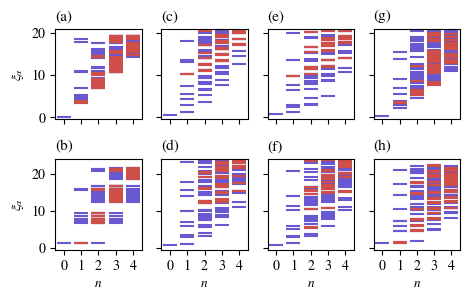

In [15]:
# m=4
fig, ax= plt.subplots(2,4, figsize=(4.8, 3.1))

fz,fzz,ftt = 9.5, 8.5, 11

clrs = ["#ce4f4aff", "#6859d1ff"]


for p in range(4):

    ss=100

    ax[0,p].scatter(x[p][:,0],z[p][:,0], marker="_", s=ss, color=clrs[1])
    
    for i in range(len(z[p][:,0])-1): # Mark degeneracies in red
        if np.abs(z[p][i,0]-z[p][i+1,0])<2.5e-1 and x[p][i,0]==x[p][i+1,0]:
            
            ax[0,p].scatter(x[p][i,0],z[p][i,0], marker="_", s=ss, color=clrs[0])
            ax[0,p].scatter(x[p][i+1,0],z[p][i+1,0], marker="_", s=ss, color=clrs[0])


    ax[1,p].scatter(x[p][:,1],z[p][:,1], marker="_", s=ss, color=clrs[1])
    
    for i in range(len(z[p][:,1])-1): # Mark degeneracies in red
        if np.abs(z[p][i,1]-z[p][i+1,1])<2.5e-1 and x[p][i,1]==x[p][i+1,1]:
            
            ax[1,p].scatter(x[p][i,1],z[p][i,1], marker="_", s=ss, color=clrs[0])
            ax[1,p].scatter(x[p][i+1,1],z[p][i+1,1], marker="_", s=ss, color=clrs[0])

for axs in ax[1,:]:
    axs.set_xlabel("$n$", fontsize=fz);
    axs.set_xticks([0,1,2,3,4,5]);
    axs.set_xlim(-0.5,4.5);
    axs.set_ylim(-0.5,24);
for axs in ax[0,:]:
    axs.set_xticks([0,1,2,3,4,5]);
    axs.set_xlim(-0.5,4.5);
    axs.set_ylim(-0.5,21);
    axs.xaxis.set_tick_params(labelleft=False)
#             axs.set_ylim(-0.5,21);

for i in range(2):
    ax[i,0].set_ylabel("$\\xi_\\alpha$", fontsize=fz);
    for axs in ax[i,1:]:
        axs.yaxis.set_tick_params(labelleft=False)

# Define variable names for the keys of dict
variables = ['a', 'c', 'e', 'g', 'b', 'd', 'f', 'h',]

# Create a dictionary using a loop
dicts = {}
for i, variable in enumerate(variables):
    key = f"({variable})"
    if i<4:
        value = ax[0, i]
    else:
        value= ax[1, i%4]
    dicts[key] = value

for key, axs in dicts.items():
    axs.set_title(key, loc='left', fontsize=ftt)

plt.tight_layout()


# filetype = ".{}".format(input("Please specify file format to save (without dot): "))
# plt.savefig("{}_EntanglementSpectrum".format(input("Please specify which system this is: "))+filetype, dpi=600, bbox_inches="tight") 
